# Comparing Centrality Metrics

This notebook analyzes and compares different centrality metrics for a citation network.

It loads node and edge data from JSON files, calculates various centrality metrics (like degree, betweenness, closeness etc.), and compares them against ground truth measures like importance and document type.

The notebook defines constants for:
- Input data file paths
- Centrality metrics to analyze 
- Ground truth measures to compare against

It also defines TypedDict classes to type the network statistics and results.

**Note:** This is an analysis notebook. To modify the code that generates the network and calculates centralities, please refer to the Main section.



In [554]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import dateutil.parser
import statistics
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import spearmanr
import seaborn as sns
import os
import json
from typing import Dict, List, Union, TypedDict, Tuple


# Types

In [555]:
class NetworkStats(TypedDict):
    n_nodes: int
    n_edges: int

class BestCentralities(TypedDict):
    high: str
    low: str

class AnalysisResults(TypedDict):
    network_stats: NetworkStats
    correlations: Dict[str, Dict[str, Dict[tuple[str, str], float]]]  # ground_truth -> composite_function -> (centrality, ground_truth) -> correlation
    best_centralities: Dict[str, BestCentralities]  # ground_truth -> best centralities
    composite_rankings: Dict[str, Dict[str, Dict[str, float]]]  # ground_truth -> composite_function -> ecli -> rank
    dataframe: pd.DataFrame

# Utils

In [556]:
# Convert doctypebranch to a numeric value
def categorise_total_branch_numerically(branches: pd.Series) -> pd.Series:
    """
    Convert branch categorisation from strings into numbers.
    
    :param branches: The column containing branch data, categorized with strings.
    :return: A pandas Series with numerical categorization.
    """
    mapping = {
        "GRANDCHAMBER": 1,
        "CHAMBER": 2,
        "COMMITTEE": 3,
    }
    
    # Convert to uppercase to ensure consistent matching
    branches = branches.str.upper()
    
    # Print any values that don't match our mapping
    unmapped = set(branches.unique()) - set(mapping.keys())
    if unmapped:
        print(f"Warning: Found unmapped values: {unmapped}")
    
    return branches.map(mapping)

def prep_data(df: pd.DataFrame, include: list) -> pd.DataFrame:
    """
    Prepare the dataset by selecting the appropriate columns and filtering out rows with uncomputed metric values.
    
    :param df: The DataFrame to process.
    :param include: Columns to include.
    :return: The processed DataFrame.
    """
    headers = include + ['ecli']  # Ensure essential columns are included
    headers = list(set(headers))  # Removing duplicates

    data = df[headers]

    # Filter out rows with uncomputed metric values (-2)
    metric_column = include[-1]
    data = data[data[metric_column] >= -1]

    return data

# Centrality Calculation

In [557]:
def calculate_disruptions_new(graph: nx.Graph) -> dict:
    """
    Calculate the disruption score for each node in the graph.

    Args:
        graph (nx.Graph): The input directed graph.

    Returns:
        dict: A dictionary with nodes as keys and their disruption scores as values.
    """
    disruptions = {}
    for node in graph.nodes:
        i, j, k = 0, 0, 0

        # count j - papers that cite both the current paper and its references
        for in_node in graph.predecessors(node):
            for out_node in graph.successors(node):
                if graph.has_edge(in_node, out_node):
                    j += 1
                    break

        # count i - papers that only cite the current paper
        i = graph.in_degree(node) - j

        # count k - papers that only cite papers cited by the current paper
        for out_node in graph.successors(node):
            for in_out_node in graph.predecessors(out_node):
                if in_out_node != node and not graph.has_edge(in_out_node, node):
                    k += 1

        # Calculate disruption index with better edge case handling
        denominator = i + j + k
        if denominator == 0:
            # If paper has no citations and cites no one, assign neutral disruption
            disruptions[node] = 0.0
        else:
            disruptions[node] = (i - j) / denominator

    # Verify we have at least some non-zero values
    values = list(disruptions.values())
    if all(v == 0 for v in values):
        print("Warning: All disruption values are 0")
    if len(set(values)) == 1:
        print(f"Warning: All disruption values are identical: {values[0]}")

    return disruptions


# Function to calculate centrality measures
def calculate_centrality_measures(graph):
    """Calculate various centrality measures for the graph."""
    measures = {
        'degree_centrality': nx.degree_centrality(graph),
        'in_degree_centrality': nx.in_degree_centrality(graph),
        'out_degree_centrality': nx.out_degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph),
        'closeness_centrality': nx.closeness_centrality(graph),
        'core_number': nx.core_number(graph),
        'relative_in_degree_centrality': {node: degree/len(graph) 
                                        for node, degree in graph.in_degree()},
        'harmonic_centrality': nx.harmonic_centrality(graph)
    }
    
    # Handle potentially failing measures with try-except
    try:
        measures['eigenvector_centrality'] = nx.eigenvector_centrality(graph, max_iter=1000)
    except (nx.PowerIterationFailedConvergence, nx.NetworkXError):
        # Fill with zeros if calculation fails
        measures['eigenvector_centrality'] = {node: 0.0 for node in graph.nodes()}
    
    try:
        measures['pagerank'] = nx.pagerank(graph)
    except:
        measures['pagerank'] = {node: 0.0 for node in graph.nodes()}
    
    try:
        hub_dict, authority_dict = nx.hits(graph)
        measures['hits_hub'] = hub_dict
        measures['hits_authority'] = authority_dict
    except:
        measures['hits_hub'] = {node: 0.0 for node in graph.nodes()}
        measures['hits_authority'] = {node: 0.0 for node in graph.nodes()}
    
    try:
        measures['disruption'] = calculate_disruptions_new(graph)
        # Check if disruption values make sense (between -1 and 1)
        disruption_values = list(measures['disruption'].values())
        if not all(-1 <= v <= 1 for v in disruption_values if not np.isnan(v)):
            raise ValueError("Disruption values outside valid range [-1,1]")
        
        # Check if all disruption values are identical (excluding NaN)
        non_nan_values = [v for v in disruption_values if not np.isnan(v)]
        if len(non_nan_values) > 0 and all(v == non_nan_values[0] for v in non_nan_values):
            raise ValueError("All disruption values are identical")
    except Exception as e:
        measures['disruption'] = {node: 0.0 for node in graph.nodes()}
        
    return measures

# Composite Ranking

In [558]:
"""
This script analyzes the relationship between various centrality measures and ground truth scores
for legal cases. It aims to find the best centrality measures for predicting high and low relevance
scores, create a composite ranking, and evaluate its performance against individual centrality measures.

The main steps are:
1. Plot error bars for centrality measures vs. ground truth scores
2. Find the best centrality measures for predicting high and low scores
3. Create a composite ranking using the best measures
4. Calculate correlations between rankings and ground truth scores
5. Visualize and save the results
"""

def plot_error_bars(df, centrality, ground_truth):
    """
    Plot error bars for a given centrality measure against a ground truth score.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centrality (str): The name of the centrality measure column
    ground_truth (str): The name of the ground truth score column

    This function visualizes the relationship between a centrality measure and a ground truth score,
    showing the mean centrality value for each ground truth score category along with error bars
    representing the standard deviation.
    """
    # Prepare data
    include = [ground_truth, centrality]
    data = prep_data(df, include)

    x_header = centrality
    y_header = ground_truth
    x, y = list(data[x_header]), list(data[y_header])
    categories = list(set(y))
    categories.sort()
    num_categories, num_instances = len(categories), len(x)
    y_instances = [[] for _ in range(num_categories)]
    for category_no in range(num_categories):
        for instance_no in range(num_instances):
            if y[instance_no] == categories[category_no]:
                y_instances[category_no].append(x[instance_no])
    x = [statistics.mean(y_instances[category_no]) for category_no in range(num_categories)]
    y = categories

    # Draw graph
    plt.figure(figsize=(10, 6))
    title = f"{centrality.capitalize()} vs Average {y_header.capitalize()}"
    plt.suptitle(title, fontsize=22)
    plt.xlabel(f"{centrality.capitalize()}", fontsize=22)
    plt.ylabel(f"{y_header.capitalize()}", fontsize=22)
    plt.yticks(categories, fontsize=16)

    # Calculate error bars
    stds = [statistics.stdev(y_instances[category_no]) for category_no in range(num_categories)]
    plt.errorbar(x, y, xerr=stds, fmt='o')

    plt.show()

def find_best_centralities(df, centralities, ground_truth):
    """
    Find the best centrality measures for predicting high and low ground truth scores.
    TODO: Include considerations for multiple ground truth scores

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truth (str): The name of the ground truth score column

    Returns:
    tuple: (best_high, best_low) - the names of the best centrality measures for high and low scores

    This function calculates the Spearman correlation between each centrality measure and the ground truth,
    using 1 - |correlation| as an error metric. The centrality with the lowest error is chosen as best_high,
    and the second-lowest (excluding best_high) is chosen as best_low.
    """

    # TODO For COURTBRANCH: When selecting the optimal metric for the lower class (less importance) we weight it against the middle class.

    errors = {}
    
    for centrality in centralities:
        # Calculate correlation across the full range
        corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
        errors[centrality] = 1 - abs(corr)  # Use 1 - |correlation| as error
    
    best_high = min(errors, key=errors.get)
    
    # Remove the best_high centrality from consideration for best_low
    errors.pop(best_high, None)
    
    best_low = min(errors, key=errors.get)
    
    return best_high, best_low


def find_best_centralities_updated(df, centralities, ground_truth):
    """
    Find the best centrality measures for predicting high and low ground truth scores.
    TODO: Include considerations for multiple ground truth scores

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truth (str): The name of the ground truth score column

    Returns:
    tuple: (best_high, best_low) - the names of the best centrality measures for high and low scores

    This function calculates the Spearman correlation between each centrality measure and the ground truth,
    using 1 - |correlation| as an error metric. The centrality with the lowest error is chosen as best_high,
    and the second-lowest (excluding best_high) is chosen as best_low.
    """

    # TODO For COURTBRANCH: When selecting the optimal metric for the lower class (less importance) we weight it against the middle class.

    errors = {}
    
    for centrality in centralities:
        # Calculate correlation across the full range
        corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
        errors[centrality] = 1 - abs(corr)  # Use 1 - |correlation| as error
    
    best_high = min(errors, key=errors.get)
    
    # Remove the best_high centrality from consideration for best_low
    errors.pop(best_high, None)
    
    best_low = min(errors, key=errors.get)
    
    return best_high, best_low

def rank_cases(df, centrality):
    """
    Rank cases based on a given centrality measure.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centrality (str): The name of the centrality measure column

    Returns:
    pd.Series: A series of rankings for each case

    This function ranks the cases in descending order of the centrality measure,
    with the highest centrality receiving rank 1.
    """
    return df[centrality].rank(ascending=False)

def create_treashold_composite_ranking(df, high_centrality, low_centrality, ground_truth):
    """
    Create a composite ranking based on a threshold approach using two centrality measures.
    
    Args:
        df: DataFrame containing the centrality measures
        high_centrality: Centrality measure that performs best for high scores
        low_centrality: Centrality measure that performs best for low scores
        ground_truth: Name of the ground truth column
        
    Returns:
        Series containing the composite ranking
    """
    # Normalize both centrality measures to [0,1] range
    high_normalized = (df[high_centrality] - df[high_centrality].min()) / (df[high_centrality].max() - df[high_centrality].min())
    low_normalized = (df[low_centrality] - df[low_centrality].min()) / (df[low_centrality].max() - df[low_centrality].min())
    
    # Find optimal threshold by testing different values
    thresholds = np.linspace(0, 1, 100)
    best_correlation = -1
    optimal_threshold = 0
    
    for threshold in thresholds:
        # Create composite ranking using current threshold
        composite = np.where(
            high_normalized > threshold,
            high_normalized,  # Use high centrality measure
            low_normalized    # Use low centrality measure
        )
        
        # Calculate correlation with ground truth
        correlation = abs(spearmanr(composite, df[ground_truth])[0])
        
        # Update if better correlation found
        if correlation > best_correlation:
            best_correlation = correlation
            optimal_threshold = threshold
    
    # Create final composite ranking using optimal threshold
    final_composite = np.where(
        high_normalized > optimal_threshold,
        high_normalized,
        low_normalized
    )
    
    print(f"Optimal threshold found: {optimal_threshold:.6f}")
    return final_composite, optimal_threshold

def create_composite_ranking(df, high_centrality, low_centrality, weight):
    """
    Create a composite ranking using two centrality measures.
    The weight is the weight given to the high_centrality ranking (0-1), different from 0 and 1.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    high_centrality (str): The name of the centrality measure best for high scores
    low_centrality (str): The name of the centrality measure best for low scores
    weight (float): The weight given to the high_centrality ranking (0-1)

    Returns:
    pd.Series: A series of composite rankings for each case

    This function creates a weighted average of the rankings from two centrality measures,
    allowing for a balance between predicting high and low ground truth scores.
    """
    high_ranks = rank_cases(df, high_centrality)
    low_ranks = rank_cases(df, low_centrality)
    return weight * high_ranks + (1 - weight) * low_ranks

def find_optimal_weight(df, high_centrality, low_centrality, ground_truth):
    """
    Find the optimal weight for creating a composite ranking. 
    The weight is the weight given to the high_centrality ranking (0-1), different from 0 and 1.
    Args:
    df (pd.DataFrame): The dataframe containing the data
    high_centrality (str): The name of the centrality measure best for high scores
    low_centrality (str): The name of the centrality measure best for low scores
    ground_truth (str): The name of the ground truth score column

    Returns:
    float: The optimal weight (0-1) for the high_centrality ranking

    This function tests different weights to find the one that produces the composite ranking
    with the highest correlation to the ground truth scores.
    """
    best_corr = -1
    best_weight = 0.5  # Initialize to middle value
    for weight in np.arange(0.01, 1.00, 0.01):  # Exclude 0 and 1
        composite = create_composite_ranking(df, high_centrality, low_centrality, weight)
        corr, _ = stats.spearmanr(composite, df[ground_truth])
        if abs(corr) > best_corr:
            best_corr = abs(corr)
            best_weight = weight
    return best_weight

def calculate_correlations(df, centralities, ground_truths, composite_ranking=None):
    """
    Calculate correlations between rankings and ground truth scores.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truths (list): List of ground truth score column names
    composite_ranking (str): The name of the composite ranking column

    Returns:
    dict: A dictionary of correlation coefficients with string keys

    This function calculates Spearman correlations between the rankings of each centrality measure
    (including the composite ranking) and each ground truth score.
    """
    correlations = {}
    
    for centrality in centralities:
        centrality_ranking = rank_cases(df, centrality)
        for ground_truth in ground_truths:
            # Check if arrays have variation before calculating correlation
            if df[centrality].nunique() > 1 and df[ground_truth].nunique() > 1:
                corr, _ = stats.spearmanr(centrality_ranking, df[ground_truth])
                correlations[(centrality, ground_truth)] = corr
            else:
                correlations[(centrality, ground_truth)] = np.nan
    
    if composite_ranking is not None:
        for ground_truth in ground_truths:
            if df[composite_ranking].nunique() > 1 and df[ground_truth].nunique() > 1:
                corr, _ = stats.spearmanr(df[composite_ranking], df[ground_truth])
                correlations[('composite', ground_truth)] = corr
            else:
                correlations[('composite', ground_truth)] = np.nan
    
    return correlations

def calculate_centrality_correlations(df, centralities, ground_truths):
    """
    Calculate correlations between rankings and ground truth scores.
    """
    correlations = {}
    for centrality in centralities:
        for ground_truth in ground_truths:
            # Check if arrays have variation before calculating correlation
            if df[centrality].nunique() > 1 and df[ground_truth].nunique() > 1:
                corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
                correlations[(centrality, ground_truth)] = corr
            else:
                correlations[(centrality, ground_truth)] = np.nan
    return correlations

def plot_correlations(correlations, ground_truth, output_file, best_high, best_low, composite_param):
    """
    Plot correlations between rankings and ground truth scores.

    Args:
    correlations (dict): Dictionary of correlation coefficients
    ground_truth (str): The name of the current ground truth score
    output_file (str): The name of the output file for the plot
    best_high (str): The name of the best centrality for high scores
    best_low (str): The name of the best centrality for low scores

    This function creates a bar plot showing the correlations between each centrality measure
    (including the composite ranking) and the ground truth scores.
    """
    centralities = list(set([k[0] for k in correlations.keys() if k[0] != 'composite']))
    ground_truths = list(set([k[1] for k in correlations.keys()]))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Add text to show which centralities were used for the composite ranking
    text = f"Composite: {best_high} (high) + {best_low} (low)"
    if composite_param is not None:
        text += f"\nComposite Param: {composite_param}"
    ax.text(0.02, 0.98, text,
            transform=ax.transAxes, ha='left', va='top', 
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.6))
    
    x = np.arange(len(ground_truths))
    width = 0.8 / (len(centralities) + 1)
    
    for i, centrality in enumerate(centralities + ['composite']):
        offset = width * i - 0.4 + width/2
        rects = ax.bar(x + offset, [correlations[(centrality, gt)] for gt in ground_truths], width, label=centrality)
    
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlations between Rankings and Ground Truths (optimized for {ground_truth})')
    ax.set_xticks(x, ground_truths)
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()

def plot_centrality_vs_ground_truth(df, centrality, ground_truth, output_path):
    """
    Plot centrality measure against ground truth metrics with error bars.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        centrality (str): Name of the centrality measure to plot
        ground_truths (list): List of ground truth measures to compare against
        output_path (str): Path to save the output plots
    """
    # Prepare data
    data = df[[ground_truth, centrality]].copy()
    data = data[data[centrality] != -2]  # Remove uncomputed values
    
    # Group by ground truth value and calculate statistics
    grouped_stats = data.groupby(ground_truth)[centrality].agg(['mean', 'std']).reset_index()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot points and error bars
    plt.errorbar(grouped_stats['mean'], 
                grouped_stats[ground_truth],
                xerr=grouped_stats['std'],
                fmt='o',  # Changed from 'o-' to 'o' to remove connecting line
                capsize=5,
                capthick=1,
                elinewidth=1,
                markersize=8)
    
    # Customize the plot
    plt.title(f'{centrality} vs. Average {ground_truth}', fontsize=16)
    plt.xlabel(centrality.replace('_', ' ').title(), fontsize=16)
    plt.ylabel(ground_truth.replace('_', ' ').title(), fontsize=16)
    plt.yticks(grouped_stats[ground_truth], fontsize=16)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{output_path}/{centrality}_{ground_truth}_error_bars.png', 
                bbox_inches='tight', 
                dpi=300)
    plt.close()

def save_correlations_to_csv(correlations, ground_truth, output_file, best_high, best_low):
    """
    Save correlation results to a CSV file.

    Args:
    correlations (dict): Dictionary of correlation coefficients
    ground_truth (str): The name of the current ground truth score
    output_file (str): The name of the output CSV file
    best_high (str): The name of the best centrality for high scores
    best_low (str): The name of the best centrality for low scores

    This function saves the correlation results to a CSV file for further analysis or reporting.
    """
    df_correlations = pd.DataFrame(correlations.items(), columns=['Pair', 'Correlation'])
    df_correlations[['Centrality', 'Ground Truth']] = pd.DataFrame(df_correlations['Pair'].tolist(), index=df_correlations.index)
    df_correlations = df_correlations.drop('Pair', axis=1)
    df_correlations.to_csv(output_file, index=False)

# Analyze Network Function
> The `analyze_network()` function performs comprehensive network analysis using various centrality measures and composite rankings.

## Input Parameters

- `nodes_df`: Pandas DataFrame containing node information, including ground truth scores and node attributes
- `edges_df`: Pandas DataFrame containing edge information (connections between nodes)  
- `ground_truths`: List of column names in nodes_df that contain ground truth scores to analyze
- `centralities`: List of centrality measures to calculate (e.g. degree, betweenness, etc.)
- `composite_functions`: List of functions that combine multiple centrality measures into composite rankings
- `output_path`: Directory path where analysis outputs will be saved

## Processing Steps

1. Creates output directory if it doesn't exist
2. Makes a copy of the input nodes DataFrame
3. For each ground truth measure:
   - Calculates an inverted version (max value - original value)
   - Stores inverted versions with "_inverted" suffix
4. Cleans data by:
   - Dropping rows with missing ECLI identifiers
   - Converting doctypebranch to numeric values if present
5. Calculates centrality measures specified
6. Creates composite rankings using provided functions
7. Computes correlations between:
   - Individual centrality measures and ground truths
   - Composite rankings and ground truths

## Return Value

Returns an `AnalysisResults` dictionary containing:
- `network_stats`: Basic statistics about the network (nodes, edges, density etc.)
- `correlations`: Correlation coefficients between rankings and ground truths
- `best_centralities`: Best performing centrality measures for each ground truth
- `composite_rankings`: Results of composite ranking calculations
- `dataframe`: Final processed DataFrame with all measures included

## Output Files

Saves various analysis results to the specified output directory, including:
- Correlation plots
- CSV files with detailed results
- Network statistics


In [559]:
def analyze_network(nodes_df: pd.DataFrame, 
                   edges_df: pd.DataFrame, 
                   ground_truths: List[str],
                   centralities: List[str],
                   composite_functions: List[str],
                   output_path: str,
                   network_name: str = None) -> Dict:
    """
    Analyze network using various centrality measures and composite rankings.
    
    Args:
        nodes_df: DataFrame containing node information
        edges_df: DataFrame containing edge information
        ground_truths: List of ground truth scores to analyze
        centralities: List of centrality measures to calculate
        composite_functions: List of functions for composite rankings
        output_path: Directory path for saving outputs
        network_name: Name of the network being analyzed (for tracking performance)
    
    Returns:
        Dict containing analysis results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Make a copy of nodes dataframe
    total_df = nodes_df.copy()

    # Convert doctypebranch to numeric if it exists
    if 'doctypebranch' in total_df.columns:
        total_df['doctypebranch'] = categorise_total_branch_numerically(total_df['doctypebranch'])
        # Remove rows with Nan doctypebranch
        total_df = total_df.dropna(subset=['doctypebranch'])

    # Convert ground truth columns to numeric
    for truth in ground_truths:
        total_df[truth] = pd.to_numeric(total_df[truth], errors='coerce')
    
    # Invert ground truth values
    ground_truths_inverted = []
    for truth in ground_truths:
        max_value = total_df[truth].max()
        inverted_col = f'{truth}_inverted'
        total_df[inverted_col] = max_value - total_df[truth]
        ground_truths_inverted.append(inverted_col)
    
    # Drop rows with missing ecli
    total_df = total_df.dropna(subset=['ecli'])
    
    # Create graph
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for idx, row in total_df.iterrows():
        node_attrs = {truth: row[truth] for truth in ground_truths if truth in row}
        G.add_node(row['ecli'], **node_attrs)
    
    # Add edges between existing nodes
    valid_nodes = set(total_df['ecli'].values)
    for idx, row in edges_df.iterrows():
        source = row['ecli']
        targets = row['references']
        if source in valid_nodes:
            for target in targets:
                if target and target in valid_nodes:
                    G.add_edge(source, target)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Calculate network statistics
    network_stats = {
        'num_nodes': len(nodes_df),
        'num_edges': len(edges_df),
        'density': nx.density(G),
        'average_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
    }
    
    # Initialize analysis dictionary
    analysis = {
        gt: {
            'centrality_counts': {
                'high': defaultdict(int),
                'low': defaultdict(int),
                'best_overall': defaultdict(int)
            },
            'combination_counts': defaultdict(int),
            'composite_performance': {
                'outperformed_count': 0,
                'best_combinations': []
            },
            'network_performance': {},  # Track performance by network
            'correlations': defaultdict(dict),  # Store all correlations
            'optimal_weights': defaultdict(float),  # Store optimal weights
            'class_distribution': {},  # Store class distribution
            'composite_rankings': {},  # Store composite rankings
            'best_centralities': {}  # Store best centralities
        } for gt in ground_truths
    }
    
    # Calculate centrality measures
    centrality_measures = calculate_centrality_measures(G)
    centrality_df = pd.DataFrame(centrality_measures)
    
    # Merge centrality measures with total_df
    total_df = pd.merge(total_df, centrality_df, left_on='ecli', right_index=True, how='left')
    
    # Plot initial correlations
    numeric_cols = total_df.select_dtypes(include=[float, int]).columns
    
    # Analyze each ground truth score
    for ground_truth in ground_truths:
        print(f"\nAnalyzing ground truth: {ground_truth}")

        for centrality in centralities:
            if centrality in numeric_cols:
                plot_centrality_vs_ground_truth(total_df, centrality, ground_truth, output_path)
        print(f"Plotted {len(centralities)} centrality vs ground truth plots")
        
        # Calculate class distribution
        class_distribution = nodes_df[ground_truth].value_counts().to_dict()
        analysis[ground_truth]['class_distribution'] = class_distribution
        
        # Calculate correlations for all centrality measures
        centrality_correlations = {}
        for centrality in centralities:
            corr, p_value = stats.spearmanr(total_df[centrality], total_df[ground_truth])
            centrality_correlations[centrality] = abs(corr)
            analysis[ground_truth]['correlations'][centrality] = {
                'correlation': corr,
                'p_value': p_value,
                'abs_correlation': abs(corr)
            }
        
        # Find best centralities
        best_high = max(centrality_correlations.items(), key=lambda x: x[1])[0]
        
        # Remove best_high from consideration for best_low
        low_correlations = {k: v for k, v in centrality_correlations.items() if k != best_high}
        best_low = max(low_correlations.items(), key=lambda x: x[1])[0]
        
        # Find best overall centrality
        best_centrality = max(centrality_correlations.items(), key=lambda x: x[1])[0]
        
        # Store best centralities
        analysis[ground_truth]['best_centralities'] = {
            'high': best_high,
            'low': best_low,
            'overall': best_centrality
        }
        
        print(f"Best high correlation: {best_high}")
        print(f"Best low correlation: {best_low}")
        
        # Update centrality counts
        analysis[ground_truth]['centrality_counts']['high'][best_high] += 1
        analysis[ground_truth]['centrality_counts']['low'][best_low] += 1
        analysis[ground_truth]['centrality_counts']['best_overall'][best_centrality] += 1
        
        # Record network-specific performance if network_name is provided
        if network_name:
            analysis[ground_truth]['network_performance'][network_name] = {
                'high': best_high,
                'low': best_low,
                'best_overall': best_centrality,
                'correlations': centrality_correlations.copy()
            }
        
        # Create and analyze composite rankings
        for composite_function in composite_functions:
            combination = f"{best_high}_{best_low}"
            
            # Create composite ranking based on function type
            if composite_function == 'weight_composite_ranking':
                # Find optimal weight and create composite ranking
                optimal_weight = find_optimal_weight(total_df, best_high, best_low, ground_truth)
                composite_ranking = create_composite_ranking(total_df, best_high, best_low, optimal_weight)
                
                # Store parameters
                analysis[ground_truth]['composite_rankings'][f'{composite_function}_param'] = optimal_weight
            else:
                composite_ranking, threshold = create_treashold_composite_ranking(total_df, best_high, best_low, ground_truth)
                analysis[ground_truth]['composite_rankings'][f'{composite_function}_param'] = threshold

            # Add composite ranking to dataframe
            ranking_col = f'composite_ranking_{ground_truth}_{composite_function}'
            total_df[ranking_col] = composite_ranking
            
            # Calculate correlations and store them
            correlations = calculate_correlations(total_df, centralities, ground_truths, ranking_col)
            analysis[ground_truth]['correlations'][composite_function] = correlations
            
            # Store composite rankings
            analysis[ground_truth]['composite_rankings'][composite_function] = total_df[ranking_col].to_dict()
            
            # Calculate correlation for composite ranking
            composite_corr, p_value = stats.spearmanr(composite_ranking, total_df[ground_truth])
            
            # Store composite ranking correlation
            analysis[ground_truth]['correlations']['composite'] = {
                'correlation': composite_corr,
                'p_value': p_value,
                'abs_correlation': abs(composite_corr)
            }
            
            # Check if composite ranking outperformed individual centralities
            if abs(composite_corr) > max(centrality_correlations.values()):
                analysis[ground_truth]['composite_performance']['outperformed_count'] += 1
                analysis[ground_truth]['composite_performance']['best_combinations'].append({
                    'combination': f"{best_high}_{best_low}",
                    'correlation': abs(composite_corr),
                    'network': network_name if network_name else 'unknown',
                    'optimal_weight': optimal_weight if composite_function == 'weight_composite_ranking' else threshold
                })
            
             # Save visualization outputs
            plot_correlations(
                correlations, 
                ground_truth, 
                f'{output_path}/correlations_plot_{ground_truth}_{composite_function}.png',
                best_high, 
                best_low, 
                analysis[ground_truth]['composite_rankings'][f'{composite_function}_param']
            )
            
            save_correlations_to_csv(
                correlations,
                ground_truth,
                f'{output_path}/correlations_{ground_truth}_{composite_function}.csv',
                best_high,
                best_low
            )
        
    correlations = calculate_centrality_correlations(total_df, centralities, ground_truths)

    # Save complete analysis results
    analysis_results = {
        'network_stats': network_stats,
        'ground_truths': ground_truths,
        'centralities': centralities,
        'composite_functions': composite_functions,
        'centrality_correlations': correlations,
        'ground_truth_analysis': {
            gt: {
                'correlations': analysis[gt]['correlations'],
                'best_centralities': analysis[gt]['best_centralities'],
                'composite_rankings': analysis[gt].get('composite_rankings', {}),
                'composite_performance': analysis[gt]['composite_performance'],
                'optimal_weights': analysis[gt].get('optimal_weights', {}),
                'class_distribution': analysis[gt]['class_distribution'],
                'centrality_counts': analysis[gt]['centrality_counts'],
                'combination_counts': analysis[gt]['combination_counts'],
                'network_performance': analysis[gt].get('network_performance', {})
            } for gt in ground_truths
        }
    }
    
    return analysis_results

# Compare Function
This section implements network comparison functionality to analyze and compare results across different networks.

The main function `compare_networks()` takes results from multiple network analyses and performs the following comparisons:

1. Correlation Comparisons:
   - Compares how different centrality measures correlate with ground truth metrics across networks
   - Creates comparison tables showing correlation values for each network
   - Saves correlation comparisons to CSV files

2. Ranking Comparisons: 
   - Analyzes how centrality measures rank relative to each other in different networks
   - Converts absolute correlation values to rankings
   - Shows which centrality measures perform consistently well across networks
   - Saves ranking comparisons to CSV files

The comparisons are performed for each combination of:
- Ground truth metrics (e.g., PageRank, degree centrality)
- Composite ranking functions (different ways of combining centrality measures)

This allows us to:
- Identify which centrality measures work best across different network types
- Understand how network structure affects centrality measure performance
- Compare the effectiveness of different composite ranking approaches


In [560]:
def compare_networks(network_results: Dict[str, Dict], output_path: str) -> Dict:
    """
    Compare centrality measure performance across different networks.
    
    Args:
        network_results: Dictionary mapping network names to their analysis results
        output_path: Path to save comparison results
    
    Returns:
        Dictionary containing aggregated analysis results per ground truth
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Get ground truths from first network
    first_network = list(network_results.values())[0]
    ground_truths = list(first_network['ground_truth_analysis'].keys())
    
    analysis = {gt: {
        'centrality_counts': {
            'high': defaultdict(int),      # Times selected as best high
            'low': defaultdict(int),       # Times selected as best low
            'best_overall': defaultdict(int)  # Times had best correlation
        },
        'combination_counts': defaultdict(int),  # Times each high+low pair was selected
        'composite_performance': {
            'outperformed_count': 0,  # Times composite ranking beat individual centralities
            'best_combinations': []    # Combinations that achieved best performance
        }
    } for gt in ground_truths}

    # Add centrality correlations to analysis
    analysis['centrality_correlations'] = {network_name: results['centrality_correlations'] for network_name, results in network_results.items()}
    
    # Analyze each network's results
    for network_name, results in network_results.items():
        for ground_truth in ground_truths:
            gt_analysis = results['ground_truth_analysis'][ground_truth]
            
            # Get best centralities
            best_high = gt_analysis['best_centralities']['high']
            best_low = gt_analysis['best_centralities']['low']
            best_overall = gt_analysis['best_centralities']['overall']
            
            # Count individual centrality selections
            analysis[ground_truth]['centrality_counts']['high'][best_high] += 1
            analysis[ground_truth]['centrality_counts']['low'][best_low] += 1
            analysis[ground_truth]['centrality_counts']['best_overall'][best_overall] += 1
            
            # Count combination selections
            combination = f"{best_high}+{best_low}"
            analysis[ground_truth]['combination_counts'][combination] += 1
            
            # Track composite performance if available
            composite_perf = gt_analysis['composite_performance']
            if composite_perf['outperformed_count'] > 0:
                analysis[ground_truth]['composite_performance']['outperformed_count'] += 1
                for combo in composite_perf['best_combinations']:
                    combo['network'] = network_name
                    analysis[ground_truth]['composite_performance']['best_combinations'].append(combo)
    
    # Save results
    for ground_truth in ground_truths:
        # Save analysis results
        results_file = f'{output_path}/network_analysis_{ground_truth}.json'
        with open(results_file, 'w') as f:
            json.dump(analysis[ground_truth], f, indent=4)
        
        # Create centrality summary DataFrame
        centrality_summary = pd.DataFrame([{
            'centrality': cent,
            'times_best_high': analysis[ground_truth]['centrality_counts']['high'][cent],
            'times_best_low': analysis[ground_truth]['centrality_counts']['low'][cent],
            'times_best_overall': analysis[ground_truth]['centrality_counts']['best_overall'][cent]
        } for cent in set(
            list(analysis[ground_truth]['centrality_counts']['high'].keys()) +
            list(analysis[ground_truth]['centrality_counts']['low'].keys()) +
            list(analysis[ground_truth]['centrality_counts']['best_overall'].keys())
        )])
        
        centrality_summary.to_csv(
            f'{output_path}/centrality_summary_{ground_truth}.csv', 
            index=False
        )
        
        # Create combination summary DataFrame
        combination_summary = pd.DataFrame([{
            'combination': comb,
            'times_selected': count
        } for comb, count in analysis[ground_truth]['combination_counts'].items()])
        
        combination_summary.to_csv(
            f'{output_path}/combination_summary_{ground_truth}.csv',
            index=False
        )
    
    return analysis

# Data Visualization

In [561]:
def plot_network_centrality_comparison(analysis: Dict, output_path: str):
    # Get all unique centralities and networks
    all_centralities = set()
    all_networks = set()
    
    # Count occurrences for each centrality in each network and ground truth
    network_counts = {}
    
    # Extract networks from centrality_correlations
    if 'centrality_correlations' in analysis:
        all_networks.update(analysis['centrality_correlations'].keys())
        
        # Generate colors dynamically based on number of networks
        import colorsys
        
        def get_colors(n):
            colors = {}
            for i, network in enumerate(sorted(all_networks)):
                # Generate evenly spaced hues
                hue = i / n
                # Create saturated color for importance
                rgb = colorsys.hsv_to_rgb(hue, 0.8, 0.9)
                main_color = f'#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}'
                # Create lighter version for doctypebranch
                rgb_light = colorsys.hsv_to_rgb(hue, 0.5, 0.9)
                light_color = f'#{int(rgb_light[0]*255):02x}{int(rgb_light[1]*255):02x}{int(rgb_light[2]*255):02x}'
                colors[network] = (main_color, light_color)
            return colors
        
        network_colors = get_colors(len(all_networks))
        
        # Initialize network_counts for each network
        for network_name in all_networks:
            network_counts[network_name] = {
                'importance': defaultdict(int),
                'doctypebranch': defaultdict(int)
            }
    
    # For each ground truth, get the network performance data
    for key in analysis:
        if key != 'centrality_correlations':
            network_performance = analysis[key].get('centrality_counts', {})
            
            # Process high performers
            high_performers = network_performance.get('high', {})
            for centrality, count in high_performers.items():
                all_centralities.add(centrality)
                for network in all_networks:
                    network_counts[network][key][centrality] += count
            
            # Process low performers
            low_performers = network_performance.get('low', {})
            for centrality, count in low_performers.items():
                all_centralities.add(centrality)
                for network in all_networks:
                    network_counts[network][key][centrality] += count
    
    if not all_networks or not all_centralities:
        print("No data to plot: empty networks or centralities")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    centralities = sorted(list(all_centralities))
    x = np.arange(len(centralities))
    
    # Plot bars for each network and ground truth
    bar_width = 0.8 / (len(all_networks) * 2)  # 2 for two ground truths
    
    for i, network in enumerate(sorted(all_networks)):
        for j, gt in enumerate(['importance', 'doctypebranch']):
            counts = [network_counts[network][gt][c] for c in centralities]
            offset = bar_width * (i * 2 + j) - (len(all_networks) * bar_width)
            
            # Get appropriate color based on ground truth
            color = network_colors[network][1] if gt == 'doctypebranch' else network_colors[network][0]
            
            bars = ax.bar(x + offset, counts, bar_width, 
                         label=f'{network} ({gt})',
                         color=color,
                         alpha=0.9)
            
            # Add value labels on top of each bar
            for bar in bars:
                height = bar.get_height()
                if height > 0:  # Only add label if bar has height
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(height)}',
                           ha='center', va='bottom')
    
    # Customize the plot
    ax.set_ylabel('Count')
    ax.set_title('Centrality Performance by Network and Ground Truth')
    plt.suptitle('Total number of times each centrality has been selected as highest predictor for either low or high scores.', fontsize=10, y=0.95)
    
    ax.set_xticks(x)
    ax.set_xticklabels(centralities, rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout and save
    plt.tight_layout()
    output_file = os.path.join(output_path, 'network_centrality_comparison.png')
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()


def create_centrality_correlation_matrix(analysis_results: Dict, output_path: str):
    """
    Create a CSV file showing correlations between centralities and ground truths across networks.
    
    Args:
        analysis_results: Dictionary containing the analysis results with structure:
            {'centrality_correlations': {
                'network_name': {
                    'ground_truth': {
                        'centrality_ground_truth': correlation_value,
                        ...
                    },
                    ...
                },
                ...
            }}
        output_path: Path to save the CSV file
    
    The CSV will have:
    - Column 1: Centrality measures
    - Remaining columns: One column per network
    - Values: Ground truth correlations formatted as "GT1: value | GT2: value"
    """
    # Get centrality correlations dictionary
    network_correlations = analysis_results['centrality_correlations']
    print(f"Found networks: {list(network_correlations.keys())}")
    
    # Extract all centralities from the data
    all_centralities = set()
    for network_data in network_correlations.values():
        for centrality, _ in network_data.keys():
            all_centralities.add(centrality)
    print(f"\nFound centralities: {sorted(list(all_centralities))}")
    
    # Extract ground truths from the first network (assuming all networks have same ground truths)
    ground_truths = set()
    for (_, gt) in network_correlations[list(network_correlations.keys())[0]].keys():
        ground_truths.add(gt)
    print(f"\nFound ground truths: {sorted(list(ground_truths))}")
    
    # Create DataFrame with just centralities and networks
    networks = sorted(network_correlations.keys())
    df = pd.DataFrame(index=sorted(list(all_centralities)), 
                     columns=['Centrality'] + networks)
    
    # Fill in centrality names
    df['Centrality'] = df.index
    print("\nInitial DataFrame:")
    print(df)
    
    # Fill in the correlation values for each network
    for network in networks:
        print(f"\nFilling data for network: {network}")
        network_data = network_correlations[network]
        
        for centrality in all_centralities:
            # Collect all ground truth correlations for this centrality
            correlations = []
            for gt in sorted(ground_truths):
                key = (centrality, gt)
                if key in network_data:
                    value = network_data[key]
                    # Capitalize first letter of ground truth and format value
                    gt_display = gt.capitalize()
                    correlations.append(f"{gt_display}: {value:.4f}")
            
            # Join all ground truth correlations with " | "
            if correlations:
                df.loc[centrality, network] = " | ".join(correlations)
            else:
                df.loc[centrality, network] = "N/A"
    
    print("\nFinal DataFrame:")
    print(df)
    
    # Save to CSV
    output_file = os.path.join(output_path, 'centrality_correlations_matrix.csv')
    df.to_csv(output_file, index=False)
    
    print(f"\nCorrelation matrix saved to {output_file}")

def visualize_network_commonalities(analysis_results: Dict, output_path: str, compare_all: bool = False, print_correlations: bool = False):
    """
    Visualize commonalities between networks focusing on centrality performance.
    Each visualization is saved separately.
    
    Args:
        analysis_results: Dictionary containing the analysis results from compare_networks()
        output_path: Path to save visualization outputs
    """
    # Set the aesthetic style
    plt.style.use('default')
    colors = {'importance': 'skyblue', 'doctypebranch': 'lightgreen'}
    
    # Helper function to add value labels
    def add_value_labels(ax, rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
    
    # 1. High Importance Performers Graph
    fig, ax = plt.subplots(figsize=(12, 8))
    for key in analysis_results:
        if key != 'centrality_correlations':  # This is a ground truth
            high_counts = analysis_results[key]['centrality_counts']['high']
            if high_counts:
                centralities = list(high_counts.keys())
                counts = list(high_counts.values())
                bars = ax.bar(centralities, counts, label=key, alpha=0.7, color=colors[key])
                add_value_labels(ax, bars)
    
    plt.ylabel('Times Selected as Best High Predictor')
    plt.title('Best Performing Centralities for High Scores')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_path}/high_performers.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # 2. Low Importance Performers Graph
    fig, ax = plt.subplots(figsize=(12, 8))
    for key in analysis_results:
        if key != 'centrality_correlations':  # This is a ground truth
            low_counts = analysis_results[key]['centrality_counts']['low']
            if low_counts:
                centralities = list(low_counts.keys())
                counts = list(low_counts.values())
                bars = ax.bar(centralities, counts, alpha=0.5, label=key, color=colors[key])
                add_value_labels(ax, bars)
    
    plt.ylabel('Times Selected as Best Low Predictor')
    plt.title('Best Performing Centralities for Low Scores')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_path}/low_performers.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # 3. Best Overall Performers Graph
    fig, ax = plt.subplots(figsize=(12, 8))
    for ground_truth in analysis_results:
        if ground_truth != 'centrality_correlations':
            best_overall = analysis_results[ground_truth]['centrality_counts']['best_overall']
            if best_overall:
                centralities = list(best_overall.keys())
                counts = list(best_overall.values())
                bars = ax.bar(centralities, counts, label=ground_truth, alpha=0.7, color=colors[ground_truth])
                add_value_labels(ax, bars)
    
    plt.ylabel('Times Selected as Highest Predictor')
    plt.title('Higest Overall Predicting Centralities')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_path}/best_overall_performers.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # 4. Combination Performance Graph
    fig, ax = plt.subplots(figsize=(12, 8))
    for key in analysis_results:
        if key != 'centrality_correlations':
            combinations = analysis_results[key]['combination_counts']
            if combinations:
                combo_names = list(combinations.keys())
                combo_counts = list(combinations.values())
                bars = ax.bar(combo_names, combo_counts, label=key, alpha=0.7, color=colors[key])
                add_value_labels(ax, bars)

    plt.ylabel('Times Selected as Highest Predictor')
    plt.title('Best Performing Centrality Combinations')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_path}/combination_performance.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # 5. Total Best Occurrences Graph
    total_counts = {}
    for key in analysis_results:
        if key != 'centrality_correlations':
            for category in ['high', 'low', 'best_overall']:
                counts = analysis_results[key]['centrality_counts'][category]
                for centrality, count in counts.items():
                    if centrality not in total_counts:
                        total_counts[centrality] = 0
                    total_counts[centrality] += count
    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    if total_counts:
        centralities = list(total_counts.keys())
        counts = list(total_counts.values())
        bars = ax.bar(centralities, counts, color='lightcoral', alpha=0.7)
        add_value_labels(ax, bars)
    
    plt.ylabel('Total Times Selected as Highest Predictor')
    plt.title('Overall Best Performing Centralities (All Categories)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{output_path}/total_best_occurrences.png', bbox_inches='tight', dpi=300)
    plt.close()

    # 6. Compare across networks
    if compare_all:
        plot_network_centrality_comparison(analysis_results, output_path) # TODO
        
    if print_correlations:
        create_centrality_correlation_matrix(analysis_results, output_path)
        
        # Create performance summary
    performance_summary = {}
    for key in analysis_results:
        if key != 'centrality_correlations':
            performance_summary[key] = {
                'best_performers': {
                    'high': None,
                    'low': None,
                    'combination': None
                },
                'composite_performance': {}
            }
            
            # Best high performer
            high_counts = analysis_results[key]['centrality_counts']['high']
            if high_counts:
                best_high = max(high_counts.items(), key=lambda x: x[1])
                performance_summary[key]['best_performers']['high'] = {
                    'centrality': best_high[0],
                    'times_selected': best_high[1]
                }
            
            # Best low performer
            low_counts = analysis_results[key]['centrality_counts']['low']
            if low_counts:
                best_low = max(low_counts.items(), key=lambda x: x[1])
                performance_summary[key]['best_performers']['low'] = {
                    'centrality': best_low[0],
                    'times_selected': best_low[1]
                }
            
            # Best combination
            combinations = analysis_results[key]['combination_counts']
            if combinations:
                best_combo = max(combinations.items(), key=lambda x: x[1])
                performance_summary[key]['best_performers']['combination'] = {
                    'combination': best_combo[0],
                    'times_selected': best_combo[1]
                }
            
            # Composite performance
            outperformed_count = analysis_results[key]['composite_performance']['outperformed_count']
            best_combinations = analysis_results[key]['composite_performance']['best_combinations']
            performance_summary[key]['composite_performance'] = {
                'outperformed_count': outperformed_count,
                'best_combinations': []
            }
            
            if best_combinations:
                combo_counts = {}
                for entry in best_combinations:
                    combo = entry['combination']
                    combo_counts[combo] = combo_counts.get(combo, 0) + 1
                
                best_outperforming = max(combo_counts.items(), key=lambda x: x[1])
                best_correlation = max(entry['correlation'] for entry in best_combinations)
                
                performance_summary[key]['composite_performance'].update({
                    'best_outperforming_combo': {
                        'combination': best_outperforming[0],
                        'times_outperformed': best_outperforming[1]
                    },
                    'highest_correlation': best_correlation,
                    'detailed_combinations': best_combinations
                })
    
        # Add overall best performer
    if total_counts:
        best_overall = max(total_counts.items(), key=lambda x: x[1])
        performance_summary['overall_best_performer'] = {
            'centrality': best_overall[0],
            'total_times_selected': best_overall[1]
        }
    
    # Save performance summary as JSON
    with open(f'{output_path}/performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=4)
    
    # Save detailed numerical results
    summary = {
        key: {
            'high_performers': dict(analysis_results[key]['centrality_counts']['high']),
            'low_performers': dict(analysis_results[key]['centrality_counts']['low']),
            'best_overall': dict(analysis_results[key]['centrality_counts']['best_overall']),
            'combinations': dict(analysis_results[key]['combination_counts']),
            'composite_performance': {
                'outperformed_count': analysis_results[key]['composite_performance']['outperformed_count'],
                'best_combinations': analysis_results[key]['composite_performance']['best_combinations']
            },
            'best_performers': {
                'high': max(analysis_results[key]['centrality_counts']['high'].items(), 
                           key=lambda x: x[1])[0] if analysis_results[key]['centrality_counts']['high'] else None,
                'low': max(analysis_results[key]['centrality_counts']['low'].items(), 
                          key=lambda x: x[1])[0] if analysis_results[key]['centrality_counts']['low'] else None,
                'overall': max(analysis_results[key]['centrality_counts']['best_overall'].items(), 
                             key=lambda x: x[1])[0] if analysis_results[key]['centrality_counts']['best_overall'] else None,
                'combination': max(analysis_results[key]['combination_counts'].items(), 
                                 key=lambda x: x[1])[0] if analysis_results[key]['combination_counts'] else None
            }
        }
        for key in analysis_results if key != 'centrality_correlations'
    }
    
    # Add total counts to summary
    summary['total_counts'] = total_counts
    
    # Save visualization summary
    with open(f'{output_path}/visualization_summary.json', 'w') as f:
        json.dump(summary, f, indent=4)

# Load Networks

In [562]:
def load_networks(path, max=100, min_nodes=50):
    """
    Load networks from a directory structure. Can handle both:
    1. Direct network files (nodes.json and edges.json in the input path)
    2. Networks in subdirectories
    
    Args:
        path: Root directory to search for networks or direct path to a network
        max: Maximum number of networks to load
    
    Returns:
        dict: Dictionary of networks with structure {network_name: {'nodes': df, 'edges': df}}
    """
    networks = {}
    loaded_count = 0
    
    # Verify root directory exists and print absolute path
    abs_root = os.path.abspath(path)
    
    if not os.path.exists(abs_root):
        raise ValueError(f"Directory {abs_root} does not exist")
        
    def is_network_dir(dir_path):
        """Check if directory contains exactly nodes.json and edges.json"""
        try:
            contents = os.listdir(dir_path)
            return ('nodes.json' in contents and 'edges.json' in contents)
        except:
            return False
    
    def load_network(dir_path, network_name, min_nodes=50):
        """Load a single network from a directory"""
        
        nodes_file = os.path.join(dir_path, 'nodes.json')
        edges_file = os.path.join(dir_path, 'edges.json')
        
        try:
            # Load and validate data
            nodes_df = pd.read_json(nodes_file)
            edges_df = pd.read_json(edges_file)
            
            # Validate required columns
            required_node_cols = ['ecli', 'importance', 'doctypebranch']
            missing_cols = [col for col in required_node_cols if col not in nodes_df.columns]
            if missing_cols:
                print(f"  Warning: Missing columns in nodes.json: {missing_cols}")
                print(f"  Available columns: {nodes_df.columns.tolist()}")
                return False
            
            required_edge_cols = ['ecli', 'references']
            missing_edge_cols = [col for col in required_edge_cols if col not in edges_df.columns]
            if missing_edge_cols:
                print(f"  Warning: Missing columns in edges.json: {missing_edge_cols}")
                print(f"  Available columns: {edges_df.columns.tolist()}")
                return False
            
            if len(nodes_df) < min_nodes:
                print(f"  Warning: Network {network_name} has fewer than {min_nodes} nodes")
                return False
            
            networks[network_name] = {
                'nodes': nodes_df,
                'edges': edges_df
            }
            return True
            
        except Exception as e:
            print(f"  Error loading network: {str(e)}")
            return False
    
    def process_directory(current_path, parent_prefix=""):
        """Recursively process directories looking for networks"""
        nonlocal loaded_count
        if loaded_count >= max:
            return
            
        # First check if current directory is a network directory
        if is_network_dir(current_path):
            # Generate network name based on path
            rel_path = os.path.relpath(current_path, abs_root)
            network_name = rel_path.replace(os.sep, '-')
            if network_name == '.':  # Handle case where path is direct to network
                network_name = os.path.basename(current_path)
            
            if load_network(current_path, network_name, min_nodes):
                loaded_count += 1
            return
        
        # If not a network directory, search subdirectories
        try:
            for item in os.listdir(current_path):
                if loaded_count >= max:
                    break
                    
                item_path = os.path.join(current_path, item)
                if not os.path.isdir(item_path):
                    continue
                    
                process_directory(item_path)
        except Exception as e:
            print(f"Error accessing directory {current_path}: {str(e)}")
    
    # Start processing from root directory
    process_directory(abs_root)
    print(f"\nSuccessfully loaded {len(networks)} networks")
    return networks

# Main

In [563]:
# Centralities of interest
CENTRALITIES = ['degree_centrality', 'in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 'core_number', 
                'relative_in_degree_centrality', 'eigenvector_centrality', 
                'pagerank', 'hits_hub', 'hits_authority', 'harmonic_centrality', 'disruption']

# Ground truths of interest
GROUND_TRUTHS = ['importance', 'doctypebranch']
GROUND_TRUTHS_INVERTED = ['importance_inverted',  'doctypebranch_inverted']

In [564]:
# # Load all networks from data/split directory
# network_results = {}

# networks = load_networks('networks')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/{network_name}'
#     )
#     network_results[network_name] = results


# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/comparisons')

In [565]:
# Test
# UNBALANCED
# network_results = {}
# networks = load_networks('networks/balanced-importance')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking'],
#         output_path=f'results/test/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/test/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/test/comparisons')

In [566]:
# # Analyse whole networks (balanced and unbalanced)
# network_results = {}

# networks = load_networks('networks/full-balanced-importance')
# networks.update(load_networks('networks/full-unbalanced'))
# networks.update(load_networks('networks/full-balanced-doctypebranch'))

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/full/{network_name}'
#     )
#     network_results[network_name] = results



# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/full/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/full/comparisons')




# # ANALYSE SPLIT NETWORKS
# # UNBALANCED
# network_results = {}
# networks = load_networks('networks/unbalanced')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/unbalanced/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/unbalanced/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/unbalanced/comparisons')



# # BALANCED BY IMPORRTANCE 
# network_results = {}
# networks = load_networks('networks/balanced-importance')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/balanced-importance/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/balanced-importance/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/balanced-importance/comparisons')



# # BALANCED BY DOCTYPEBRANCH
# network_results = {}
# networks = load_networks('networks/balanced-doctypebranch')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/balanced-doctypebranch/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/balanced-doctypebranch/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/balanced-doctypebranch/comparisons')

In [567]:
# # Analyse whole networks (balanced and unbalanced)
# network_results = {}

# networks = load_networks('networks/full-balanced-importance')
# networks.update(load_networks('networks/full-unbalanced'))
# networks.update(load_networks('networks/full-balanced-doctypebranch'))

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/branch-update/full/{network_name}'
#     )
#     network_results[network_name] = results



# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/branch-update/full/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/branch-update/full/comparisons')




# # ANALYSE SPLIT NETWORKS
# # UNBALANCED
# network_results = {}
# networks = load_networks('networks/unbalanced')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/branch-update/unbalanced/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/branch-update/unbalanced/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/branch-update/unbalanced/comparisons')



# # BALANCED BY IMPORRTANCE 
# network_results = {}
# networks = load_networks('networks/balanced-importance')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/branch-update/balanced-importance/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/branch-update/balanced-importance/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/branch-update/balanced-importance/comparisons')



# # BALANCED BY DOCTYPEBRANCH
# network_results = {}
# networks = load_networks('networks/balanced-doctypebranch')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/balanced-doctypebranch/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/balanced-doctypebranch/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/balanced-doctypebranch/comparisons')

## Test Compilation

In [568]:
# TEST
# network_results = {}

# splitTest = load_networks('networks/merged/split-balanced-importance')
# # Sort networks by size and take the 8 biggest ones
# splitTest = dict(sorted(splitTest.items(), key=lambda x: len(x[1]['nodes']), reverse=True)[:3])



# # Analyze Networks
# for network_name, data in splitTest.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/test/split-balanced-importance/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")

# # Compare results across networks
# analysis = compare_networks(network_results, 'results/test/split-balanced-importance/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/test/split-balanced-importance/comparisons')



# # FOR TESTING, SELECT THE 3 BIGGEST NETWORKS
# print("TESTING CROSS-NETWORK CORRELATIONS")
# # Sort networks by size and take the 3 biggest ones

# # Analyze Networks
# analysis = compare_networks(network_results, 'results/test/full/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/test/full/comparisons', print_correlations=True, compare_all=True)


In [569]:
# # Analyse whole networks (balanced and unbalanced)
# network_results = {}

# networks = load_networks('networks/full-balanced-importance')
# networks.update(load_networks('networks/full-unbalanced'))
# networks.update(load_networks('networks/full-balanced-doctypebranch'))

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/branch-update/full/{network_name}'
#     )
#     network_results[network_name] = results



# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/branch-update/full/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/branch-update/full/comparisons')




# # ANALYSE SPLIT NETWORKS
# # UNBALANCED
# network_results = {}
# networks = load_networks('networks/unbalanced')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/branch-update/unbalanced/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/branch-update/unbalanced/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/branch-update/unbalanced/comparisons')



# # BALANCED BY IMPORRTANCE 
# network_results = {}
# networks = load_networks('networks/balanced-importance')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/branch-update/balanced-importance/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/branch-update/balanced-importance/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/branch-update/balanced-importance/comparisons')



# # BALANCED BY DOCTYPEBRANCH
# network_results = {}
# networks = load_networks('networks/balanced-doctypebranch')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/balanced-doctypebranch/{network_name}'
#     )
#     network_results[network_name] = results

# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/balanced-doctypebranch/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/balanced-doctypebranch/comparisons')  

## Full Compilation
- Analise entire network 
- Split between balanced and unbalanced
- Differentiate sets of networks between minimum node count


Looking for networks in: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/merged/full-unbalanced

Checking network: full-unbalanced
  Path: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/merged/full-unbalanced
  Loading data files...
  Successfully loaded network with 6450 nodes and 1121 edges

Successfully loaded 1 networks
Looking for networks in: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/merged/full-balanced-importance

Checking network: full-balanced-importance
  Path: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/merged/full-balanced-importance
  Loading data files...
  Successfully loaded network with 6450 nodes and 1121 edges

Successfully loaded 1 networks
Looking for networks in: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/merged/full-balanced-doctypebranch

Checking network: full-balanced-doctypebranch
  Path: /Users/davidwickerhf/Proje

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1060e1f40>>
Traceback (most recent call last):
  File "/Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 



Analyzing ground truth: importance


FileNotFoundError: [Errno 2] No such file or directory: '/Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/results/test/split-50/full-balanced-importance/degree_centrality_importance_error_bars.png'

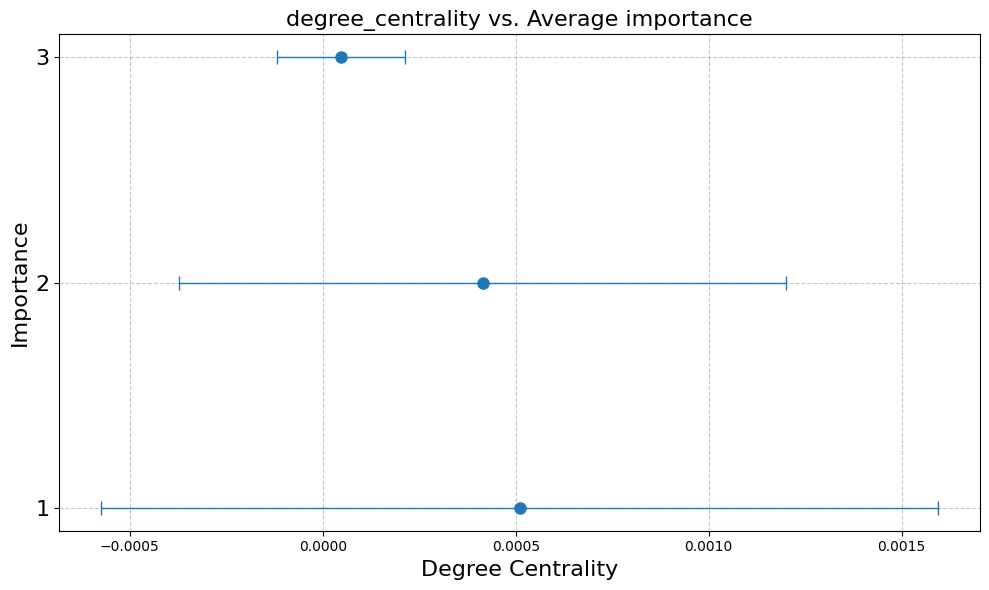

In [570]:
# LOAD COMPLETE NETWORKS (min 50 nodes)
network_results = {}

# Load full complete networks
full_unbalanced = load_networks('networks/merged/full-unbalanced')
full_balanced_importance = load_networks('networks/merged/full-balanced-importance')
full_balanced_doctypebranch = load_networks('networks/merged/full-balanced-doctypebranch')

# Print detailed statistics for full networks
print("\n=== Full Network Statistics ===\n")

# Print statistics for all network types
for network_type, network_data in [
    ("Unbalanced Network:", full_unbalanced),
    ("Balanced (Importance) Network:", full_balanced_importance), 
    ("Balanced (Doctype/Branch) Network:", full_balanced_doctypebranch)
]:
    print(f"\n{network_type}")
    for name, data in network_data.items():
        print(f"Nodes: {len(data['nodes'])}")
        print(f"Edges: {len(data['edges'])}")
        
        # Get importance distribution
        importance_dist = data['nodes']['importance'].value_counts()
        print("\nImportance Distribution:")
        for imp, count in importance_dist.items():
            print(f"  {imp}: {count} ({count/len(data['nodes'])*100:.1f}%)")
            
        # Get doctype/branch distribution
        doctype_dist = data['nodes']['doctype_branch'].value_counts()
        print("\nDoctype/Branch Distribution:")
        for doc, count in doctype_dist.items():
            print(f"  {doc}: {count} ({count/len(data['nodes'])*100:.1f}%)")
        print()


# Load full split networks
split_unbalanced = load_networks('networks/merged/split-unbalanced')
split_balanced_importance = load_networks('networks/merged/split-balanced-importance')
split_balanced_doctypebranch = load_networks('networks/merged/split-balanced-doctypebranch')

# Form networks with min 100 nodes
importance_merged_100_cutoff_unbalanced = {name: data for name, data in split_unbalanced.items() if len(data['nodes']) >= 100}
importance_merged_100_cutoff_balanced_importance = {name: data for name, data in split_balanced_importance.items() if len(data['nodes']) >= 100}
importance_merged_100_cutoff_balanced_doctypebranch = {name: data for name, data in split_balanced_doctypebranch.items() if len(data['nodes']) >= 100}

# Form networks with min 150 nodes
importance_merged_150_cutoff_unbalanced = {name: data for name, data in split_unbalanced.items() if len(data['nodes']) >= 150}
importance_merged_150_cutoff_balanced_importance = {name: data for name, data in split_balanced_importance.items() if len(data['nodes']) >= 150}
importance_merged_150_cutoff_balanced_doctypebranch = {name: data for name, data in split_balanced_doctypebranch.items() if len(data['nodes']) >= 150}


full_networks = [full_unbalanced, full_balanced_importance, full_balanced_doctypebranch]
split_networks_50 = [split_unbalanced, split_balanced_importance, split_balanced_doctypebranch]
split_networks_100 = [importance_merged_100_cutoff_unbalanced, importance_merged_100_cutoff_balanced_importance, importance_merged_100_cutoff_balanced_doctypebranch]
split_networks_150 = [importance_merged_150_cutoff_unbalanced, importance_merged_150_cutoff_balanced_importance, importance_merged_150_cutoff_balanced_doctypebranch]

# Define your network sets
all_iterations = [full_networks, split_networks_50, split_networks_100, split_networks_150]
iteration_names = ['importance-merged', 'importance-merged-50-cutoff', 'importance-merged-100-cutoff', 'importance-merged-150-cutoff']

# Process each set separately
for iteration, name in zip(all_iterations, iteration_names):
    print(f"\n=== Processing {name} networks ===")
    
    # Set output path
    output_base = f'results/{name}'
    
    # Create base directory if it doesn't exist
    os.makedirs(output_base, exist_ok=True)
    
    # Process each type within the iteration (unbalanced, balanced_importance, balanced_doctypebranch)
    for i, network_set in enumerate(iteration):
        if i == 0:
            print("\nAnalyzing Unbalanced Networks")
            set_name = "unbalanced"
        elif i == 1:
            print("\nAnalyzing Balanced Networks (Importance)")
            set_name = "balanced-importance"
        elif i == 2:
            print("\nAnalyzing Balanced Networks (Doctype/Branch)")
            set_name = "balanced-doctypebranch"
            
        # Skip empty network sets
        if not network_set:
            print(f"No networks in {set_name} set")
            continue
            
        # Create set directory
        set_path = os.path.join(output_base, set_name)
        os.makedirs(set_path, exist_ok=True)
        os.makedirs(os.path.join(set_path, 'comparisons'), exist_ok=True)
        
        network_results = {}
        
        # Analyze each network in the set
        for network_name, data in network_set.items():
            print(f"\nAnalyzing network: {network_name}")
            try:
                results = analyze_network(
                    nodes_df=data['nodes'],
                    edges_df=data['edges'],
                    ground_truths=GROUND_TRUTHS,
                    centralities=CENTRALITIES,
                    composite_functions=['weight_composite_ranking'],
                    output_path=os.path.join(set_path, network_name)
                )
                network_results[network_name] = results
            except Exception as e:
                print(f"Error analyzing network {network_name}: {str(e)}")
                continue

        # Compare results within this specific set
        if network_results:
            try:
                analysis = compare_networks(network_results, os.path.join(set_path, 'comparisons'))
                visualize_network_commonalities(
                    analysis, 
                    os.path.join(set_path, 'comparisons'),
                    print_correlations=True,
                    compare_all=True
                )
                print(f"Successfully completed analysis for {name} - {set_name}")
            except Exception as e:
                print(f"Error in comparison/visualization for {name} - {set_name}: {str(e)}")
        else:
            print(f"No results to compare for {name} - {set_name}")